# Neural ODEs - II
We here show how to implement, using ```heyoka```, the traning pipeline for NeuralODE replicating this [torcheqdiff demo](https://github.com/rtqichen/torchdiffeq/blob/master/examples/ode_demo.py).
We will be using the very same parameters and dynamics, but only implement a simple fixed learning rate stochastic grdient descent.

See also:
* [Neural ODEs I](<./NeuralODEs_I.ipynb>)
* [Neural Hamiltonian ODEs](<./NeuralHamiltonianODEs.ipynb>)

In [1]:
# The usual main imports
import heyoka as hy
import numpy as np
import time

%matplotlib inline
import matplotlib.pyplot as plt

## Generating the ground truth

The dynamics we consider is a simple third order system:

$$
\left\{
\begin{array}{l}
\dot x = -0.1 x^3 - 2y^3 \\
\dot y = 2 x^3 - 0.1y^3 
\end{array}
\right.
$$

which we implement in ``heyoka`` as:

In [2]:
x, y = hy.make_vars("x", "y")
# We now assemble the dynamics
A = np.array([[-0.1, 2.0], [-2.0, -0.1]])
tmp = np.array([[x * x * x, y * y * y]]) @ A
dyn = [(x, tmp[0][0]), (y, tmp[0][1])]

The observations have the following parameters:

In [3]:
# This is the number of observations (i.e. the ground truth).
data_size = 1000
# This is the initial condition used to generate the observations (i.e. the ground truth).
ic = [2.0, 0.0]
# This is the time grid used to generate the observations (i.e. the ground truth).
t_grid = np.linspace(0.0, 25, data_size)

We start by instantiating the {class}`~heyoka.taylor_adaptive` object that will generate our observations. These will be considered as ground truth. Note that in other settings this data may be observed from a real phenomena, rather than generated numerically.

In [4]:
start_time = time.time()
ta = hy.taylor_adaptive(
    # The ODEs.
    dyn,
    # The initial conditions.
    ic,
    # Do not operate in compact mode.
    compact_mode=False,
    # Define the tolerance
    tol=1e-18,
)
print(
    "--- %s seconds --- to build (jit) the Taylor integrator"
    % (time.time() - start_time)
)

--- 0.14019465446472168 seconds --- to build (jit) the Taylor integrator


We are thus ready to generate the the ground truth using the {func}`~heyoka.taylor_adaptive.propagate_grid()` method of the Taylor adaptive integrator.

In [5]:
# It is good practice to always set initial conditions explicitly
ta.time = 0
ta.state[:] = ic
# This is our ground truth (gt)
gt = ta.propagate_grid(t_grid)[5]

Let us have a look at the generated observations.

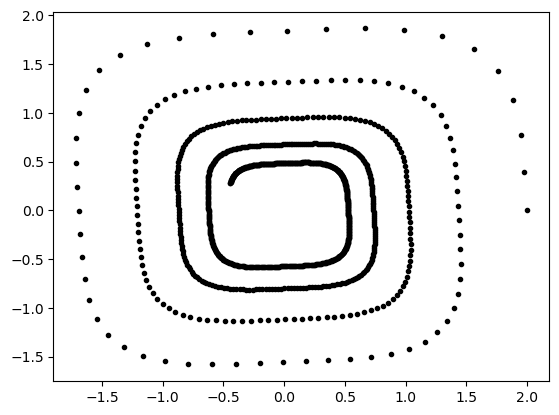

In [6]:
plt.plot(gt[:, 0], gt[:, 1], 'k.')

## Instantiating the neural ODE

So far we have only generated the data we want to teach our Neural ODE to replicate. We now need to instantiate the Neural ODE system so that we can make predictions and compute the gradient of our loss.
Let us start with instantiating a feed-forward neural network using {class}`~heyoka.models.ffnn`.

In [7]:
# We define as nonlinearity a simple linear layer
linear = lambda inp: inp

# We call the factory to construct a FFNN. Following the torcheqdiff example here we put cubes as inputs:
ffnn = hy.model.ffnn(
    inputs=[x * x * x, y * y * y],
    nn_hidden=[50],
    n_out=2,
    activations=[hy.tanh, linear],
)

We are now able to build a {class}`~heyoka.taylor_adaptive` numerical integrator which will propagate the dynamics:

$$
\left\{
\begin{array}{l}
\dot x = \mathcal N_{\theta, x}(x^3, y^3) \\
\dot y = \mathcal N_{\theta, y}(x^3, y^3) \\
\end{array}
\right.
$$

And since we will want to be able to compute the sensitivities of this ODE we are going to also augment such dynamics with the first order variational equations:

In [8]:
# We decide on whether to use single or double precision. In this example it may
# Not be too important, but this can give quite a speedup when connected with ensamble propagation.
# The single precision does effect, though, the gradient direction.
precision = np.double  # np.double

# We thus define the neural dynamics
dyn_n = [(x, ffnn[0]), (y, ffnn[1])]

# We augment it with the variational one (only order 1 - i.e. gradient)
var_dyn_n = hy.var_ode_sys(dyn_n, args=hy.var_args.params, order=1)

# And instantiate the variational integrator
start_time = time.time()
ta_var = hy.taylor_adaptive(
    # The ODEs.
    var_dyn_n,
    # The initial conditions.
    np.array(ic, dtype=precision),
    # Operate in compact mode.
    compact_mode=True,
    # Define the tolerance (low tolerance is enough here)
    tol=precision(1e-4),
    # Single precision is enough here
    fp_type=precision,
)
print(
    "--- %s seconds --- to build (jit) the Taylor integrator"
    % (time.time() - start_time)
)

# We store for convenience the initial conditions of the variational state
ic_var = list(ta_var.state[2:])

--- 0.7196767330169678 seconds --- to build (jit) the Taylor integrator


Before starting the training, we define the details on the batch we are going to use in the generic step of stochastic gradient descent:

In [9]:
# This is the number of initial conditions to use in one batch (M)
batch_size_ic = 20
# This is the number of observations to predict from each sampled initial condition (T)
batch_size_time = 10

This helper function extracts the information on a randomly generated batch:

In [10]:
def get_batch(t_grid, gt, batch_size_ic=20, batch_size_time=10):
    # We select the initial conditions from which generate predictions
    s = np.random.choice(
        np.arange(gt.shape[0] - batch_size_time, dtype=np.int64),
        batch_size_ic,
        replace=False,
    )
    batch_ic = gt[s, :]  # (M, D)
    # Assuming uniform grid and a non-autonomous system, all predictions will be made on the same time grid
    batch_t_grid = t_grid[:batch_size_time]  # (T)
    batch_y = np.stack([gt[s + i] for i in range(batch_size_time)])  # (T,M,D)
    return batch_ic, batch_t_grid, batch_y

Let us visualize what a batch looks like. First we generate one:

In [11]:
batch_ic, batch_t_grid, batch_y = get_batch(t_grid, gt, batch_size_ic, batch_size_time)

Then we plot it overlapped to all the observations:

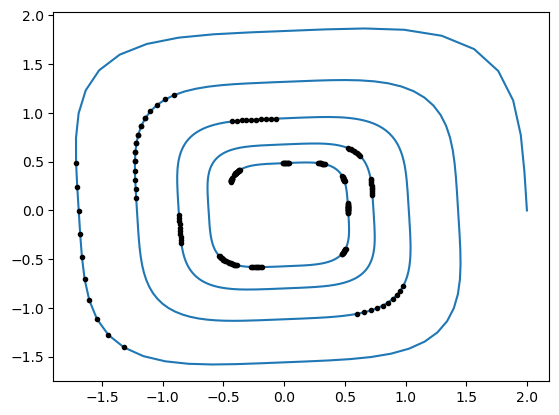

In [12]:
plt.plot(gt[:, 0], gt[:, 1])
for i in range(batch_size_ic):
    plt.plot(batch_y[:, i, 0], batch_y[:, i, 1], "k.")

We initialize the network weights and biases.

In [13]:
# We compute initialization values for weigths / biases
n_pars = len(ta_var.pars)
nn_wb = np.random.normal(loc=0, scale=0.1, size=(n_pars,))

And visualize the prediction of the starting random network.

--- 0.017654895782470703 seconds --- to compute prediction over the whole batch


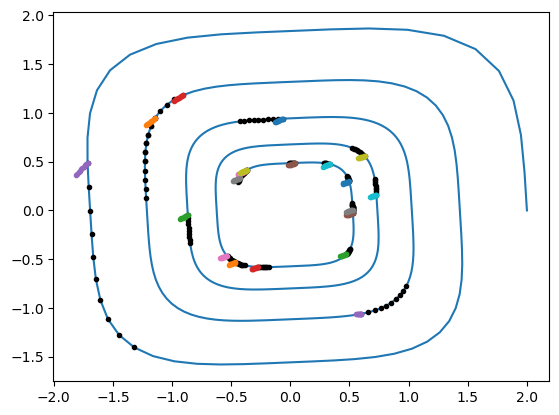

In [14]:
plt.plot(gt[:, 0], gt[:, 1])
for i in range(batch_size_ic):
    plt.plot(batch_y[:, i, 0], batch_y[:, i, 1], "k.")

start_time = time.time()
for one_ic in batch_ic:
    ta_var.time = precision(0.0)
    ta_var.state[:] = list(one_ic) + ic_var
    ta_var.pars[:] = np.array(nn_wb, dtype=precision)
    sol = ta_var.propagate_grid(np.array(batch_t_grid, dtype=precision))[5]
    plt.plot(sol[:, 0], sol[:, 1], ".")
print(
    "--- %s seconds --- to compute prediction over the whole batch"
    % (time.time() - start_time)
)

## Training

To train we need to first compute the gradient of the loss over the batch (M initial conditions and T times). Formally

$$
\mathcal L_{\theta} = \sum_{i=0}^{M}\sum_{j=0}^T (\pmb y_{ij} - \hat {\pmb y}_{ij})\cdot (\pmb y_{ij} - \hat {\pmb y}_{ij})
$$

$$
\frac{\partial L_\theta}{\partial \theta} =  2 \sum_{i=0}^{M}\sum_{j=0}^T (\pmb y_{ij} - \hat {\pmb y}_{ij})\cdot \frac{\partial \pmb y_{ij}}{\partial \theta}
$$
This helper function computes the loss and the gradient over one batch. The gradient is computed rearranging the ODE sensitivities computed propagating the variational dynamics:

In [15]:
def loss_and_gradient(nn_wb, batch_ic, batch_y):
    # We loop over the various selected initial conditions and produce the predictions
    # and their gradients
    # We reset the batch_loss value
    batch_loss = 0
    # We reset the gradient loss
    grad = np.array([0.0] * len(ta_var.pars))
    for i, ic_ in enumerate(batch_ic):
        ta_var.time = precision(0.0)
        ta_var.state[:] = list(ic_) + ic_var
        ta_var.pars[:] = np.array(nn_wb, dtype=precision)
        sol = ta_var.propagate_grid(np.array(batch_t_grid, dtype=precision))[5]
        # Here is the term (y-y_hat)
        diff = sol[:, :2] - batch_y[:, i, :]
        # Which is now summed sum sum (y-y_hat).(y-y_hat)
        batch_loss += np.sum(diff**2)
        # And the gradient computed  as 2 sum (y-y_hat).dy
        for dy in sol[:, 2:].reshape(batch_y.shape[0], 2, -1):
            grad += 2 * np.sum(diff @ dy, axis=0)
    # We then take the mean over the points used
    batch_loss /= batch_size_ic * batch_size_time
    grad /= batch_size_ic * batch_size_time
    return batch_loss, grad

Using the various blocks defined above the training loop takes the form:

In [19]:
# We loop over the epochs
n_epochs = 3000
for i in range(n_epochs):
    # 1 - generate a batch
    batch_ic, batch_t_grid, batch_y = get_batch(
        t_grid, gt, batch_size_ic=20, batch_size_time=10
    )
    # 2 - compute the loss and gradient on the batch
    batch_loss, grad = loss_and_gradient(nn_wb, batch_ic, batch_y)
    print(f"iter: {i}, loss : {batch_loss:.3e}", end="\r")
    # 3 - update the weights and biases (learning rate here is fixed, we use a naive update rule which in this case works)
    nn_wb = nn_wb - 0.1 * grad

We are now ready to visualize the result of the learned neural ODE:

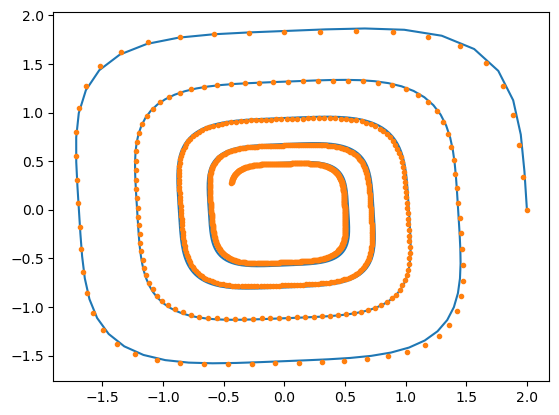

In [20]:
plt.plot(gt[:, 0], gt[:, 1])

ta_var.time = precision(0)
ta_var.state[:] = ic + ic_var
ta_var.pars[:] = np.array(nn_wb, dtype=np.single)
sol = ta_var.propagate_grid(np.array(t_grid, dtype=precision))[5]
plt.plot(sol[:, 0], sol[:, 1], ".")

It is also of interest to visualize the predictions of the trained system over a new random batch, as opposed to the predictions of the entire trajectory from the first observation:

--- 0.028968334197998047 seconds --- to compute prediction over the whole batch


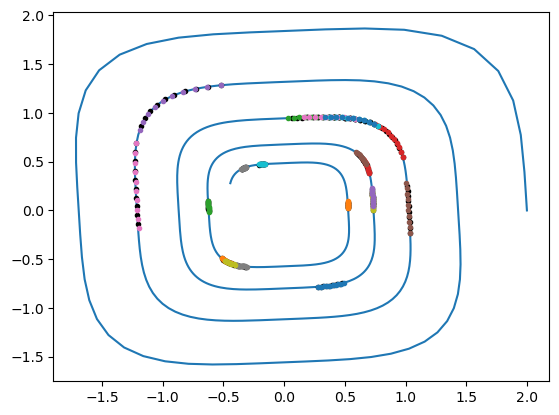

In [21]:
batch_ic, batch_t_grid, batch_y = get_batch(t_grid, gt, batch_size_ic, batch_size_time)

plt.plot(gt[:, 0], gt[:, 1])
for i in range(batch_size_ic):
    plt.plot(batch_y[:, i, 0], batch_y[:, i, 1], "k.")

start_time = time.time()
for one_ic in batch_ic:
    ta_var.time = precision(0.0)
    ta_var.state[:] = list(one_ic) + ic_var
    ta_var.pars[:] = np.array(nn_wb, dtype=precision)
    sol = ta_var.propagate_grid(np.array(batch_t_grid, dtype=precision))[5]
    plt.plot(sol[:, 0], sol[:, 1], ".")
print(
    "--- %s seconds --- to compute prediction over the whole batch"
    % (time.time() - start_time)
)